# 1 - Practical

In [21]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt

The objective of this part of the coursework is to implement three different ways of valuing put and call options.

Take two numbers, $X_1 = 120$ and $X_2$ calculated as follows. Take your student number, remove zeros and use the remaining digits to make the number closest to $100$. For example, if your student number is $100966240$, after dropping 0s you get $196624$ and can make the number $96$. Do not put your student number on your submission to preserve anonymity.

Consider options with strike prices $X_1$ and $X_2$ of $4$ types (European and American puts and calls) with the time to maturity equal to 6 months (1/2 of a year). 

In total this amounts to 8 different options.
Suppose the following holds:
- current stock price S0 is 100p;
- annual volatility is 20%;
- money can be invested at the annual interest rate (with continuous compounding) of 5% and the investment is virtually riskless; money can be borrowed at the same rate.

You should code up the Black–Scholes formula, binomial trees, and Monte Carlo algorithm, and find the following 20 numbers:
- the prices of the European call and put options computed from the Black–Scholes formula (4 numbers);
- the prices of the European and American call and put options computed using the binomial tree method (with approximately 1 day as the time step) (8 numbers);
- the prices of the European call and put options computed using the Monte Carlo method (with approximately 1 day as the time step) (4 numbers).

In the lectures several variations of each method were considered (e.g., different types of trees or simulations based on different SDEs). It is sufficient to choose one variant. Doing several variants will be considered an extra advantage, but it is not required.
- Hint 1: It is easier to measure time in years (fractions of a year), rather than in days.
- Hint 2: Different methods should return similar values for the same price.
For example, the prices of European options calculated using the Black-Scholes formula, binomial trees, and Monte-Carlo should be the same (or very close, usually within 0.1p).
- Hint 3: If you use Java, you will need to calculate the distribution function N of the Gaussian distribution ϕ(0, 1). You can use the method from the file `CNDF.java` provided on Moodle.

In [22]:
S0: int = 100
X1: int = 120
X2: int = 96  # This value is based on your student number as described in the question
r: float = 0.05
sigma: float = 0.2
T: float = 0.5
N: int = 365  # Approximate number of days in 6 months

## Binomial Trees

In [23]:
def binomial_tree(S0: int, X: int, r: float, sigma: float, T: float, N: int, option: str, option_type: str) -> float:
    dt: float = T/N
    u: float = np.exp(sigma*np.sqrt(dt))
    d: float = 1/u
    p: float = (np.exp(r*dt) - d) / (u - d)

    stock_price: list[float] = np.zeros((N + 1, N + 1))
    option_price: list[float] = np.zeros((N + 1, N + 1))

    for i in range(N + 1):
        for j in range(i + 1):
            stock_price[j][i] = S0*(u**(i-j))*(d**j)

    if option_type == 'call' and option == 'european':
        option_price[:, N] = np.maximum(np.zeros(N+1), stock_price[:, N] - X)
    elif option_type == 'put' and option == 'european':
        option_price[:, N] = np.maximum(np.zeros(N+1), X - stock_price[:, N])
    elif option_type == 'call' and option == 'american':
        option_price[:, N] = np.maximum(np.zeros(N+1), stock_price[:, N] - X)
    elif option_type == 'put' and option == 'american':
        option_price[:, N] = np.maximum(np.zeros(N+1), X - stock_price[:, N])
    else:
        raise ValueError("Invalid option type")

    for i in range(N - 1, -1, -1):
        for j in range(i + 1):
            option_price[j][i] = (
                p*option_price[j][i+1] + (1-p) * option_price[j + 1][i + 1]) / np.exp(r * dt)
            if option_type == 'call' and option == 'american':
                option_price[j][i] = np.maximum(
                    option_price[j][i], stock_price[j][i] - X)
            elif option_type == 'put' and option == 'american':
                option_price[j][i] = np.maximum(
                    option_price[j][i], X - stock_price[j][i])

    return option_price[0][0]


In [24]:
binomial_european_call_X1 = binomial_tree(S0, X1, r, sigma, T, N, 'european', 'call')
binomial_european_put_X1 = binomial_tree(S0, X1, r, sigma, T, N, 'european', 'put')
binomial_american_call_X1 = binomial_tree(S0, X1, r, sigma, T, N, 'american' ,'call')
binomial_american_put_X1 = binomial_tree(S0, X1, r, sigma, T, N, 'american' , 'put')
binomial_european_call_X2 = binomial_tree(S0, X2, r, sigma, T, N, 'european', 'call')
binomial_european_put_X2 = binomial_tree(S0, X2, r, sigma, T, N, 'european', 'put')
binomial_american_call_X2 = binomial_tree(S0, X2, r, sigma, T, N, 'american' , 'call')
binomial_american_put_X2 = binomial_tree(S0, X2, r, sigma, T, N, 'american' , 'put')

print("European call option X1: ", binomial_european_call_X1)
print("European put option X1: ", binomial_european_put_X1)
print("American call option X1: ", binomial_american_call_X1)
print("American put option X1: ", binomial_american_put_X1)
print("European call option X2: ", binomial_european_call_X2)
print("European put option X2: ", binomial_european_put_X2)
print("American call option X2: ", binomial_american_call_X2)
print("American put option X2: ", binomial_american_put_X2)

European call option X1:  1.021482664849677
European put option X1:  18.058672108250214
American call option X1:  1.021482664849677
American put option X1:  20.0
European call option X2:  9.22387521633163
European put option X2:  2.8536267710520584
American call option X2:  9.22387521633163
American put option X2:  2.985307430987258


## Monte Carlo

In [25]:
def monte_carlo(S0: int, X: int, r: float, sigma: float, T:float, N: int, M: int, option_type: str) -> float:
    dt: float = T/N
    stock_price: list[float] = np.zeros((M, N+1))
    stock_price[:, 0] = S0
    exercise: list[float] = np.zeros((M, N+1))

    for i in range(1, N+1):
        z: list[float] = np.random.normal(size = M)
        stock_price[:, i] = stock_price[:, i-1] * np.exp((r - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*z)

    if option_type == 'call':
        option_price = np.maximum(np.zeros(M), stock_price[:, N] - X)
    elif option_type == 'put':
        option_price = np.maximum(np.zeros(M), X - stock_price[:, N])
    elif option_type == 'american_call':
        for i in range(N-1, -1, -1):
            for j in range(M):
                if stock_price[j][i] - X > exercise[j][i+1]:
                    exercise[j][i] = stock_price[j][i] - X
                else:
                    exercise[j][i] = exercise[j][i+1]/np.exp(r*dt)
        option_price = np.maximum(np.zeros(M), exercise[:, 0])
    elif option_type == 'american_put':
        for i in range(N-1, -1, -1):
            for j in range(M):
                if X - stock_price[j][i] > exercise[j][i+1]:
                    exercise[j][i] = X - stock_price[j][i]
                else:
                    exercise[j][i] = exercise[j][i+1]/np.exp(r*dt)
        option_price = np.maximum(np.zeros(M), exercise[:, 0])
    else:
        raise ValueError("Invalid option type")

    option_price: float = np.exp(-r*T) * np.mean(option_price)

    return option_price


In [26]:
M: int = 10000  # Number of simulations

monte_european_call_X1 = monte_carlo(S0, X1, r, sigma, T, N, M, 'call')
monte_european_put_X1 = monte_carlo(S0, X1, r, sigma, T, N, M, 'put')
monte_american_call_X1 = monte_carlo(S0, X1, r, sigma, T, N, M, 'american_call')
monte_american_put_X1 = monte_carlo(S0, X1, r, sigma, T, N, M, 'american_put')
monte_european_call_X2 = monte_carlo(S0, X2, r, sigma, T, N, M, 'call')
monte_european_put_X2 = monte_carlo(S0, X2, r, sigma, T, N, M, 'put')
monte_american_call_X2 = monte_carlo(S0, X2, r, sigma, T, N, M, 'american_call')
monte_american_put_X2 = monte_carlo(S0, X2, r, sigma, T, N, M, 'american_put')

print("European call option X1: ", monte_european_call_X1)
print("European put option X1: ", monte_european_put_X1)
print("American call option X1: ", monte_american_call_X1)
print("American put option X1: ", monte_american_put_X1)
print("European call option X2: ", monte_european_call_X2)
print("European put option X2: ", monte_european_put_X2)
print("American call option X2: ", monte_american_call_X2)
print("American put option X2: ", monte_american_put_X2)

European call option X1:  1.0276060445494293
European put option X1:  17.900177093578982
American call option X1:  1.8742433521151485
American put option X1:  28.296948273954545
European call option X2:  9.209788702640191
European put option X2:  2.8453830295539606
American call option X2:  16.124686664897677
American put option X2:  5.704716222823398


## Black-Scholes

In [27]:
def black_scholes(S0: int, X: int, r: float, sigma: float, T: float, option_type: str) -> float:
    d1: float = (np.log(S0 / X) + (r + 0.5 * sigma ** 2)*T) / (sigma * np.sqrt(T))
    d2: float = d1 - sigma * np.sqrt(T)

    if option_type == 'call':
        option_price: float = S0 * norm.cdf(d1) - X * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == 'put':
        option_price: float = X * np.exp(-r * T) * norm.cdf(-d2) - S0 * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type")

    return option_price

In [28]:
black_european_call_X1 = black_scholes(S0, X1, r, sigma, T, 'call')
black_european_put_X1 = black_scholes(S0, X1, r, sigma, T, 'put')
black_european_call_X2 = black_scholes(S0, X2, r, sigma, T, 'call')
black_european_put_X2 = black_scholes(S0, X2, r, sigma, T, 'put')

print("European call option X1: ", black_european_call_X1)
print("European put option X1: ", black_european_put_X1)
print("European call option X2: ", black_european_call_X2)
print("European put option X2: ", black_european_put_X2)

European call option X1:  1.0226152225558796
European put option X1:  18.05980466595578
European call option X2:  9.222233623917731
European put option X2:  2.8519851786376655


## Comparison

In [56]:
def compare_methods(monte_carlo_price, binomial_price, black_scholes_price, *limits):
    # plot the results bar chart
    fig, ax = plt.subplots()
    ax.bar(['Monte Carlo', 'Binomial', 'Black-Scholes'], [monte_carlo_price, binomial_price, black_scholes_price])
    ax.set_ylim(limits[0], limits[1])
    ax.set_ylabel('Option price')
    ax.set_title('Comparison of option pricing methods')
    plt.show()

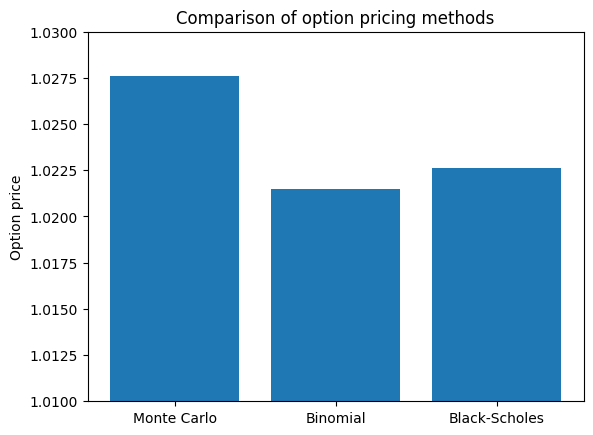

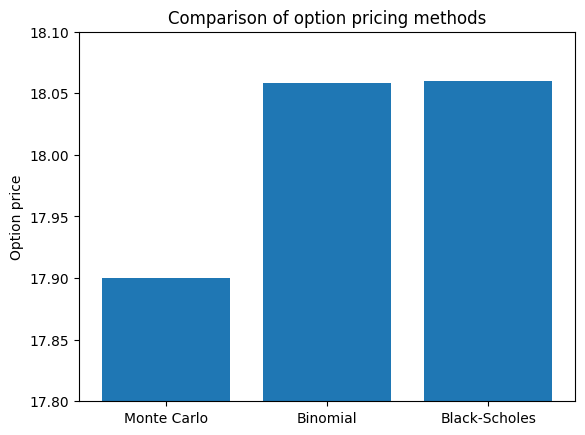

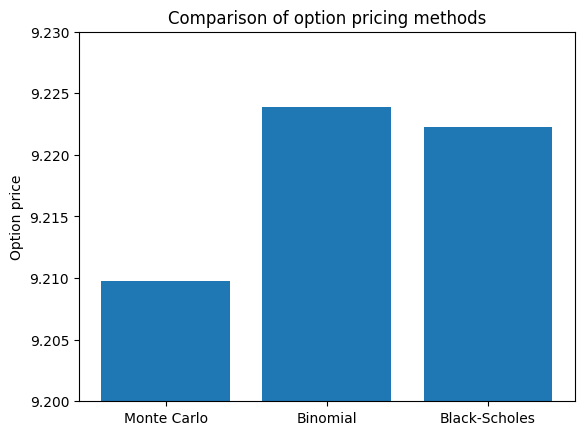

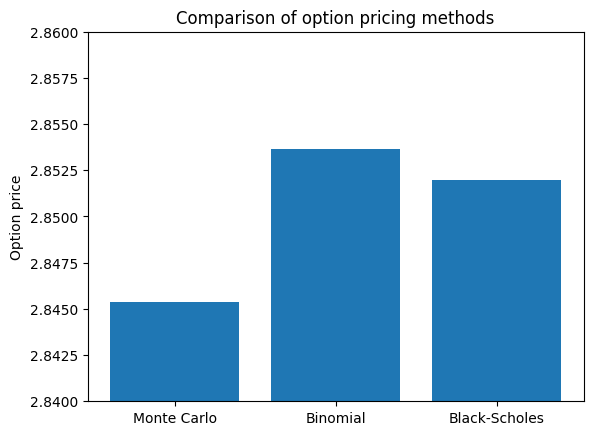

In [63]:
compare_methods(monte_european_call_X1, binomial_european_call_X1, black_european_call_X1, 1.01, 1.03)
compare_methods(monte_european_put_X1, binomial_european_put_X1, black_european_put_X1, 17.8, 18.1)
compare_methods(monte_european_call_X2, binomial_european_call_X2, black_european_call_X2, 9.2, 9.23)
compare_methods(monte_european_put_X2, binomial_european_put_X2, black_european_put_X2, 2.84, 2.86)